# 07 - Beyond Confounders


## Good Controls

We've seen how adding additional controls to our regression model can help identify causal effect. If the control is a confounder, adding it to the model is not just nice to have, but is a requirement. When the unwary see this, a natural response is to throw whatever he can measure into the model. In today's world of big data, this could easily be more than 1000 variables. As it turns out, this is not only unnecessary, but can be detrimental to causal identification. We will now turn our attention to controls that are not confounders. First, let's take a look at the good ones. Then, we will delve into harmful controls.

As a motivating example, let's suppose you are a data scientist in the collections team of a fintech. Your next task is to figure out the impact of sending an email asking people to negotiate their debt. Your response variable is the amount of payments from the late customers.

To answer this question, your team selects 5000 random customers from your late customers base to do a random test. For every customer, you flip a coin, if its heads, the customer receives the email; otherwise, it is left as a control. With this test, you hope to find out how much extra money the email generates.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import graphviz as gr

style.use("fivethirtyeight")

In [2]:
data = pd.read_csv("./data/collections_email.csv")
data.head()

,payments,email,opened,agreement,credit_limit,risk_score
0,740,1,1.0,0.0,2348.495260,0.666752
1,580,1,1.0,1.0,334.111969,0.207395
2,600,1,1.0,1.0,1360.660722,0.550479
3,770,0,0.0,0.0,1531.828576,0.560488
4,660,0,0.0,0.0,979.855647,0.455140


Since the data is random, you know that a simple difference in means estimates the Average Treatment Effect. In other words, nothing can have caused the treatment but the randomisation, so the potential outcomes are independent of the treatment: $(Y_0, Y_1)\perp T$. 

$
ATE = E[Y|T=1] - E[Y|T=0]
$

Since you are smart and want to place a confidence interval around your estimate, you use a linear regression.

In [3]:
print("Difference in means:",
      data.query("email==1")["payments"].mean() - data.query("email==0")["payments"].mean())

model = smf.ols('payments ~ email', data=data).fit()
model.summary().tables[1]

Difference in means: -0.6202804021329484


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,669.9764,2.061,325.116,0.000,665.937,674.016
email,-0.6203,2.941,-0.211,0.833,-6.387,5.146


Sadly, the estimated ATE is -0.62, which is pretty weird. How can sending an email make late customers pay less than average? Still, the P-value is so high that this probably doesn't mean anything. What you should do now? Go back to your team with a tail between your legs and say that the test is inconclusive and you need more data? Not so fast.

Notice how your data has some other interesting columns. For example, `credit_limit` represents the customer's credit line prior to he or she getting late. `risk_score` corresponds to the estimated risk of the customer prior to the delivery of the email. It makes sense to think that credit limit and risk are probably very good predictors of payments. But how can that be useful?

First, let's understand why we can fail to find statistical significance in a treatment even when it is there. It could be that, like in this case, the treatment has very little impact on the outcome. If you think about it, what makes people pay their debt is, by and large, factors outside the control of the collections department. People pay their debt because they find a new job, manage their finances, income and so on. In statistical terms, we can say that **the variability of payments is explained much more by other factors other than by the email**. 

To get a visual understanding of it, we can plot the payments against the treatment variable email. I've also plotted the fitted line of the model above in red. To help visualization, I've added a little bit of noise to the email variable so that it doesn't get smashed at the zero or one. 

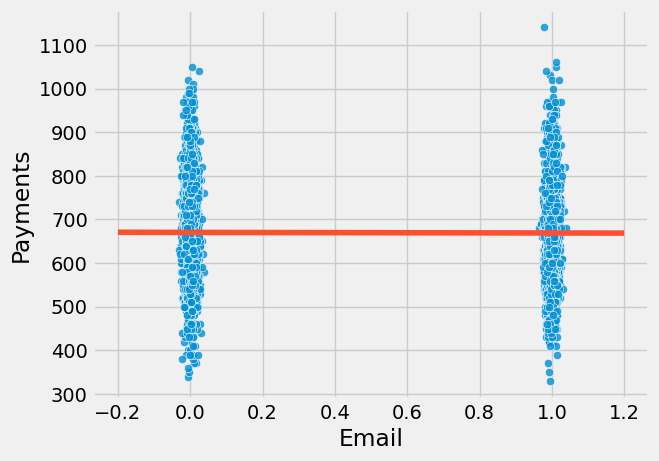

In [4]:
sns.scatterplot(x="email", y="payments", 
                alpha=0.8,
                data=data.assign(email=data["email"] + np.random.normal(0, 0.01, size=len(data["email"]))))
plt.plot(np.linspace(-0.2, 1.2), model.params[0] + np.linspace(-1, 2) * model.params[1], c="C1")
plt.xlabel("Email")
plt.ylabel("Payments");

We can see how wildly payments vary in a single treatment group. Visually, it looks like it is going from a little bit under 400 to 1000 in both groups. If the impact of the email is in the order of say 5.00 or 10.00 R$, it is no wonder it will be hard to find it inside all the variability.

Fortunately, regression can help us lower this variability. The trick is to use additional controls. **If a variable is a good predictor of the outcome, it will explain away a lot of its variance**. If risk and credit limit are good predictors of payment, we can control them to make it easier to find the impact of the email on payments. If we remember how regression works, this has an intuitive explanation. Adding extra variables to a regression means keeping them constant while looking at the treatment. So, the reasoning goes, if we look at similar levels of risk and credit limit, the variance of the response variable `payments` should be smaller. Or, in other words, if risk and credit line predicts payments very well, customers with a similar risk and credit line should also have similar payment levels, hence with less variance.

![img](./data/img/beyond-conf/y-pred.png)

To demonstrate this, let's resort to the partialling out way of breaking regression into 2 steps. First, we will regress the treatment, email, and the outcome, payments, on the additional controls, credit limit and risk score. Second, we will regress the residual of the treatment on the residuals of payments, both obtained in step 1. (This is purely pedagogical, in practice you won't need to go through all the hassle).

In [5]:
model_email = smf.ols('email ~ credit_limit + risk_score', data=data).fit()
model_payments = smf.ols('payments ~ credit_limit + risk_score', data=data).fit()

residuals = pd.DataFrame(dict(res_payments=model_payments.resid, res_email=model_email.resid))

model_treatment = smf.ols('res_payments ~ res_email', data=residuals).fit()

In [6]:
model_email.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,0.3548,0.064,5.515,0.000,0.229,0.481
credit_limit,-0.0002,5.32e-05,-3.490,0.000,-0.000,-8.14e-05
risk_score,0.7444,0.255,2.919,0.004,0.245,1.244


In [7]:
model_payments.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,492.4370,9.689,50.825,0.000,473.443,511.431
credit_limit,0.1502,0.008,18.747,0.000,0.135,0.166
risk_score,-4.7536,38.404,-0.124,0.901,-80.042,70.535


This lowers the variance of the dependent variable. By regressing payments on credit limit and risk and obtaining the residuals for this model, we are creating a new dependent variable with much less variability than the original one. The last model also uncovers the `ATE` with valid standard error estimate.

Just out of curiosity, we can also check that the model that predicts the treatment should not be able to lower the variance of it. That's because email is, by design, random, so nothing can predict it.

In [8]:
print("Payments Variance", np.var(data["payments"]))
print("Payments Residual Variance", np.var(residuals["res_payments"]))

Payments Variance 10807.612416
Payments Residual Variance 5652.453558466208


Notice how the variance of payments went from 10807 to 5652. We've decreased it by almost half once we control for risk and credit limits.

In [9]:
print("Email Variance", np.var(data["email"]))
print("Email Residual Variance", np.var(residuals["res_email"]))

Email Variance 0.24991536
Email Residual Variance 0.24918421069820032


Also notice that we didn't manage to reduce the variability of the treatment email. This makes sense, since risk and credit line does not predict email (nothing does, by definition of randomness).

In [10]:
model_treatment.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-5.812e-14,1.063,-5.47e-14,1.000,-2.084,2.084
res_email,4.4304,2.129,2.080,0.038,0.256,8.605




Now, we see something much more reasonable. This new estimate tells us that we should expect customers that received the email to pay, on average, 4.4 reais more than those in the control group. This estimate is now statistically different from zero. We can also visualize how the variance is now lower within each control group.

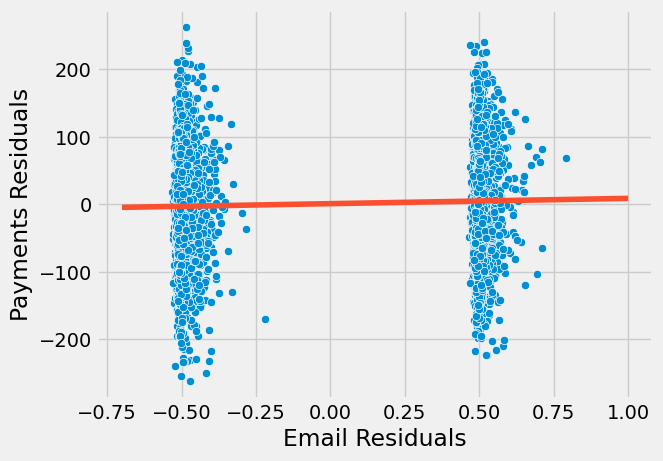

In [11]:
sns.scatterplot(x="res_email", y="res_payments", data=residuals)
plt.plot(np.linspace(-0.7, 1), model_treatment.params[0] + np.linspace(-1, 2) * model_treatment.params[1], c="C1")
plt.xlabel("Email Residuals")
plt.ylabel("Payments Residuals");

As I've said, we did this for pedagogical reasons. In practice, you can simply add the controls to the regression model together with the treatment and the estimates will be exactly the same.

In [12]:
model_2 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


To wrap it up, anytime we have a control that is a good predictor of the outcome, even if it is not a confounder, adding it to our model is a good idea. It helps lowering the variance of our treatment effect estimates. Here is a picture of what this situation looks like with causal graphs.

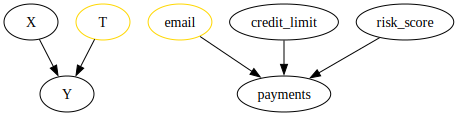

In [13]:
g = gr.Digraph()
g.edge("X", "Y"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("email", color="gold")
g.edge("credit_limit", "payments")
g.edge("risk_score", "payments")
g.edge("email", "payments")

g

## Mostly Harmful Controls

As a second motivating example, let's consider a drug test scenario with 2 hospitals. Both of them are conducting randomised trials on a new drug to treat a certain illness. The outcome of interest is days hospitalised. If the treatment is effective, it will lower the amount of days the patient stays in the hospital. For one of the hospitals, the policy regarding the random treatment is to give it to 90% of its patients while 10% get a placebo. The other hospital has a different policy: it gives the drug to a random 10% of its patients and 90% get a placebo. You are also told that the hospital that gives 90% of the true drug and 10% of placebo usually gets more severe cases of the illness to treat. 

In [14]:
hospital = pd.read_csv("./data/hospital_treatment.csv")
hospital.head()

,hospital,treatment,severity,days
0,1,1,29.686618,82
1,1,1,20.050340,57
2,1,1,20.302399,49
3,0,0,10.603118,44
4,0,0,8.332793,15


In [15]:
hospital.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hospital   80 non-null     int64  
 1   treatment  80 non-null     int64  
 2   severity   80 non-null     float64
 3   days       80 non-null     int64  
dtypes: float64(1), int64(3)
memory usage: 2.6 KB


Since you are dealing with randomized data, your first instinct is to simply run a regression of the outcome on the treatment.

In [16]:
hosp_1 = smf.ols('days ~ treatment', data=hospital).fit()
hosp_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,33.2667,2.662,12.498,0.000,27.968,38.566
treatment,14.1533,3.367,4.204,0.000,7.451,20.856


But you find some counterintuitive results. How can the treatment be increasing the number of days in the hospital? The answer lies in the fact that we are running 2 different experiments. Severity is positively linked with more days at the hospital and since the hospital with more severe cases also gives more of the drug, the drug becomes positively correlated with more days at the hospital. When we look at both hospitals together, we have that $E[Y_0|T=0]<E[Y_0|T=1]$, that is, the potential outcome of the untreated is, on average, lower than that of the treated because there are more untreated in the hospital with less severe cases. In other words, severity acts as a confounder, determining the hospital the patient goes and, hence, the probability of receiving the drug. 

There are 2 ways of fixing that. The first one, which defeats the purpose of using data from both hospitals, is to simply look at the ATE in each hospital individually.

In [17]:
hosp_2 = smf.ols('days ~ treatment', data=hospital.query("hospital==0")).fit()
hosp_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,30.4074,2.868,10.602,0.000,24.523,36.292
treatment,-11.4074,10.921,-1.045,0.306,-33.816,11.001


In [18]:
hosp_3 = smf.ols('days ~ treatment', data=hospital.query("hospital==1")).fit()
hosp_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,59.0000,6.747,8.745,0.000,45.442,72.558
treatment,-10.3958,6.955,-1.495,0.141,-24.371,3.580


In this case, we did get an intuitive result of the ATE. It looks like now the drug is in fact lowering the amount of days at the hospital. However, since we are looking at each hospital individually, there are not enough data points. As a consequence, we are unable to find statistically significant results.

In [19]:
hospital['hospital'].value_counts()

1    51
0    29
Name: hospital, dtype: int64

The other approach, which leverages the power of regression, is to control for severity by including it in the model.

In [20]:
hosp_4 = smf.ols('days ~ treatment + severity', data=hospital).fit()
hosp_4.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.6641,2.000,5.832,0.000,7.681,15.647
treatment,-7.5912,2.269,-3.345,0.001,-12.110,-3.073
severity,2.2741,0.154,14.793,0.000,1.968,2.580


The question that arises next is, should we also include hospital in the model? After all, we know that hospitals cause the treatment right? Well, that is true, but once we've controlled for severity, hospital is no longer correlated with the outcome number of days hospitalised. And we know that to be a confounder a variable has to cause both the treatment and the outcome. In this case, we have a variable that only causes the treatment.

Here is a picture of what this situation looks like with causal graphs.

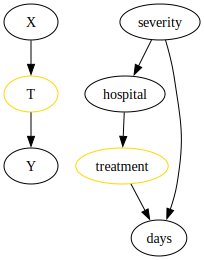

In [21]:
g = gr.Digraph()

g.edge("X", "T"), g.edge("T", "Y")
g.node("T", color="gold")

g.node("treatment", color="gold")
g.edge("severity", "hospital")
g.edge("severity", "days")
g.edge("hospital", "treatment")
g.edge("treatment", "days")

g


But maybe controlling for it lowers the variance, right? Well, not true again. In order for a control to lower the variance, it has to be a good predictor of the outcome, not of the treatment, which is the case here.

Still, we might want to control it right? It can't hurt... Or can it?

In [22]:
hosp_5 = smf.ols('days ~ treatment + severity + hospital', data=hospital).fit()
hosp_5.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,11.0111,2.118,5.198,0.000,6.792,15.230
treatment,-5.0945,3.492,-1.459,0.149,-12.049,1.861
severity,2.3865,0.195,12.251,0.000,1.999,2.774
hospital,-4.1535,4.413,-0.941,0.350,-12.943,4.636


Surprisingly, it can hurt! 

![img](./data/img/beyond-conf/shocked.png)

Adding hospital on top of severity as a control introduced MORE variance to our ATE estimator. How can that be? The answer lies in the formula for the standard error of the regression coefficient.

Sample variance of $X$:

$
s^2_X = \frac{1}{n-1} \sum(x_i - \bar{x})^2
$

Estimated variance of the error term:

$
\hat{\sigma}^2 = \dfrac{1}{n-2} \sum( y_i - \hat{y}_i )^2
$

Variance of the estimated slope coefficient:

$
\text{Var}(\hat{\beta}_2) = \dfrac{\sigma^2}{\sum(x_i - \bar{x})^2} = 
$

Standard Error (SE) of the estimated slope coefficient:

$
\text{SE}(\hat{\beta}_2) = \sqrt{\text{Var}(\hat{\beta}_2)} = \sqrt{\dfrac{\sigma^2}{\sum(x_i - \bar{x})^2}} = \sqrt{\dfrac{\sigma^2}{(n-1) s^2_X}}
$



From this formula, we can see that the standard error is inversely proportional to the variance of the variable $X$. This means that, if $X$ doesn't change much, it will be hard to estimate its effect on the outcome. This also makes intuitive sense. Take it to the extreme and pretend you want to estimate the effect of a drug, so you conduct a test with 10000 individuals but only 1 of them get the treatment. This will make finding the ATE very hard, we will have to rely on comparing a single individual with everyone else. Another way to say this is that we need lots of variability in the treatment to make it easier to find its impact. 

As to why including hospitals in the model increases the error of our estimate, it is because it is a good predictor of the treatment and not of the outcome (once we control for severity). So, by predicting the treatment, it effectively makes it so that it's variance is lower! Once again, we can resort to partitioning our regression above into it's 2 steps to see this.

In [23]:
model_treatment = smf.ols('treatment ~ severity + hospital', data=hospital).fit()
model_days = smf.ols('days ~ severity + hospital', data=hospital).fit()

residuals = pd.DataFrame(dict(res_days=model_days.resid, res_treatment=model_treatment.resid))

model_treatment = smf.ols('res_days ~ res_treatment', data=residuals).fit()

model_treatment.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,3.828e-14,0.827,4.63e-14,1.000,-1.646,1.646
res_treatment,-5.0945,3.447,-1.478,0.143,-11.957,1.768


In [24]:
print("Treatment Variance", np.var(hospital["treatment"]))
print("Treatment Residual Variance", np.var(residuals["res_treatment"]))

Treatment Variance 0.234375
Treatment Residual Variance 0.05752909187211906


Also, don't take my word for it! You can check that the SE formula above is true:

In [25]:
sigma_hat = sum(model_treatment.resid**2)/(len(model_treatment.resid)-2)
var = sigma_hat/sum((residuals["res_treatment"] - residuals["res_treatment"].mean())**2)
print("SE of the Coeficient:", np.sqrt(var))

SE of the Coeficient: 3.4469737674869023


So the bottom line is that we should add controls that are both correlated with the treatment and the outcome (confounder), like the severity in the model above. We should also add controls that are good predictors of the outcome, even if they are not confounders, because they lower the variance of our estimates. However, we should **NOT** add controls that are just good predictors of the treatment, because they will increase the variance of our estimates.

## Bad Controls - Selection Bias

Let's go back to the collections email example. Remember that the email was randomly assigned to customers. We've already explained what `credit_limit` and `risk_score` is. Now, let's look at the remaining variables. `opened` is a dummy variable for the customer opening the email or not. `agreement` is another dummy marking if the customers contacted the collections department to negotiate their debt, after having received the email. Which of the following models do you think is more appropriate? The first is a model with the treatment variable plus `credit_limit` and `risk_score`; the second adds `opened` and `agreement` dummies.

In [26]:
email_1 = smf.ols('payments ~ email + credit_limit + risk_score', data=data).fit()
email_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,490.8653,9.715,50.527,0.000,471.820,509.911
email,4.4304,2.130,2.080,0.038,0.255,8.606
credit_limit,0.1511,0.008,18.833,0.000,0.135,0.167
risk_score,-8.0516,38.424,-0.210,0.834,-83.379,67.276


In [27]:
email_2 = smf.ols('payments ~ email + credit_limit + risk_score + opened + agreement', data=data).fit()
email_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,488.4416,9.716,50.272,0.000,469.394,507.489
email,-1.6095,2.724,-0.591,0.555,-6.949,3.730
credit_limit,0.1507,0.008,18.809,0.000,0.135,0.166
risk_score,-2.0929,38.375,-0.055,0.957,-77.325,73.139
opened,3.9808,3.914,1.017,0.309,-3.692,11.654
agreement,11.7093,4.166,2.811,0.005,3.542,19.876


While the first model finds statistically significant results for the email, the second one does not. But maybe the second one is the right model and there's no effect for the email. After all, this model controls for more factors, so it should be more robust right? By now you probably know that this is not the case. What is left is to figure out what is.

We know that we MUST add confounding variables. Variables that cause both the treatment and the outcome. We also know that it is a good idea to add controls that predict the outcome very well. This is not required, but it's nice to have. We also know that it is a bad idea to add controls that predict only the treatment. Again, this is not a deadly sin, but is nice to avoid. So what kind of controls are `opened` and `agreement`? Turns out, they are neither of the above.

If you think about it, `opened` and `agreement` are surely correlated with the email. After all, you can't open the email if you didn't receive it and we've also said that the agreement only considers renegotiation that happened after the email has been sent. But **they don't cause email! Instead, they are caused by it!** 

Whenever I need to understand what kind of variables I'm dealing with, I always like to think about their causal graph. Let's do these here

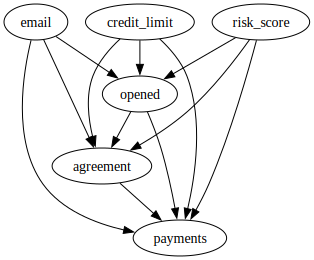

In [28]:
g = gr.Digraph()

g.edge("email", "payments")
g.edge("email", "opened")
g.edge("email", "agreement")
g.edge("opened", "payments")
g.edge("opened", "agreement")
g.edge("agreement", "payments")

g.edge("credit_limit", "payments")
g.edge("credit_limit", "opened")
g.edge("credit_limit", "agreement")
g.edge("risk_score", "payments")
g.edge("risk_score", "opened")
g.edge("risk_score", "agreement")

g

We know nothing causes email, because it's random by design. And we know (or at least we have strong reasons to believe) that credit limit and risk cause payments. We also think that email causes payments. As for `opened`, we think that it does cause payments. Intuitively, people that opened the collection email are more willing to negotiate and pay their debt. We also think that `opened` causes agreements for the same reasons as it causes payments. Moreover, we know `opened` is caused by email and we have reasons to believe people with different risk and credit limits have different open rates for the emails, so credit limit and risk also causes opened. As for agreement, we also think that it is caused by `opened`. If we think about the payments response variable, we can think of is as the result of a funnel:

$
email -> opened -> agreement -> payment 
$

We also think that different levels of risk and line have different propensity of doing an agreement, so we will mark them as also causing agreement. As for email and agreement, we could make an argument that some people just read the subject of the email and that makes them more likely to make an agreement. The point is that email could also cause agreement without passing through open.

What we notice with this graph is that opened and agreement are both in the causal path from email to payments. So, if we control for them with regression, we would be saying "this is the effect of email while keeping `opened` and `agreement` fixed". However, both are part of the causal effect of the email, so we don't want to hold them fixed. Instead, we could argue that email increases payments precisely because it boosts the agreement rate. If we fix those variables, we are removing some of the true effect from the email variable. 

With potential outcome notation, we can say that, due to randomization $E[Y_0|T=0] = E[Y_0|T=1]$. However, even with randomization, when we control for agreement, treatment and control are no longer comparable. In fact, with some intuitive thinking, we can even guess how they are different:


$
E[Y_0|T=0, Agreement=0] > E[Y_0|T=1, Agreement=0]
$

$
E[Y_0|T=0, Agreement=1] > E[Y_0|T=1, Agreement=1]
$

The first equation makes it explicit that we think those without the email and the agreement are better than those with the email and without the agreement. That is because, if the treatment has a positive effect, those that didn't make an agreement **even after having received the email** are probably worse in terms of payments compared to those that also didn't do the agreement but also didn't get the extra incentive of the email. As for the second equation, those that did the agreement even without having received the treatment are probably better than those that did the agreement but had the extra incentive of the email. 

This might be very confusing the first time you read it (it was for me), but make sure you understand it. Read it again if necessary. Then, a similar kind of reasoning can be done with the opened variable. Try to make it yourself.

This sort of bias is so pervasive it has its own name. While confounding is the bias from failing to control for a common cause, **selection bias is when we control for a common effect or a variable in between the path from cause to effect.** As a rule of thumb, always include confounders and variables that are good predictors of $Y$ in your model. Always exclude variables that are good predictors of only $T$, mediators between the treatment and outcome or common effect of the treatment and outcome.

![img](./data/img/beyond-conf/selection.png)

Selection bias is so pervasive that not even randomization can fix it. Better yet, it is often introduced by the ill advised, even in random data! Spotting and avoiding selection bias requires more practice than skill. Often, they appear underneath some supposedly clever idea, making it even harder to uncover. Here are some examples of selection biased I've encountered:

    1. Adding a dummy for paying the entire debt when trying to estimate the effect of a collections strategy on payments.
    2. Controlling for white vs blue collar jobs when trying to estimate the effect of schooling on earnings
    3. Controlling for conversion when estimating the impact of interest rates on loan duration
    4. Controlling for marital happiness when estimating the impact of children on extramarital affairs
    5. Breaking up payments modeling E[Payments] into one binary model that predict if payment will happen and another model that predict how much payment will happen given that some will: E[Payments|Payments>0]*P(Payments>0)
    
What is notable about all these ideas is how reasonable they sound. Selection bias often does. Let this be a warning. As a matter of fact, I myself have fallen into the traps above many many times before I learned how bad they were. One in particular, the last one, deserves further explanation because it looks so clever and catches lots of data scientists off guard. It's so pervasive that it has its own name: **The Bad COP**!

### Bad COP

The situation goes like this. You have a continuous variable that you want to predict but its distribution is overrepresented at zero. For instance, if you want to model consumer spending, you will have something like a gamma distribution, but with lots of zeros.

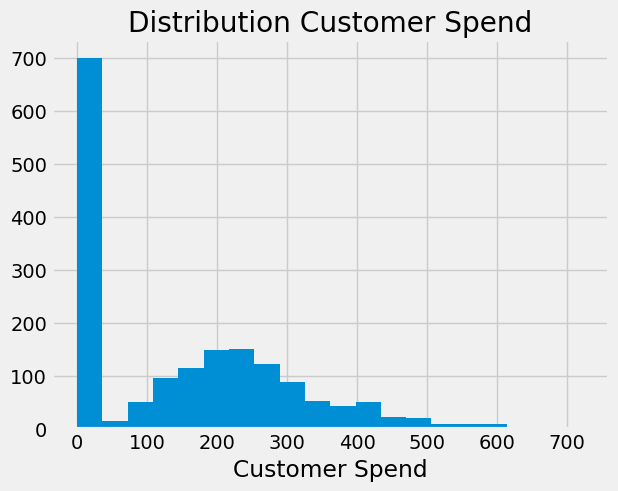

In [29]:
plt.hist(np.concatenate([
    np.random.gamma(5, 50, 1000), 
    np.zeros(700)
]), bins=20)
plt.xlabel("Customer Spend")
plt.title("Distribution Customer Spend");

When a data scientist sees this, the first idea that pops into his head is to break up modeling into 2 steps. The first is the participation, that is, the probability that $Y > 0$. In our spend example, this would be modeling if the customer decided to spend or not. The second part models $Y$ for those that decided to participate. It is the Conditional-on-Positives effect. In our case, this would be how much the customer spends after he or she decided they would spend anything. If we would like to estimate the effect of the treatment $T$ on expenditures, it would look something this:
 
$
E[Y|T] = E[Y|Y>0, T]P(Y>0|T)
$
 
There is nothing wrong with the participation model $P(Y_i>0|T_i)$. In fact, if $T$ is randomly assigned, it will capture the increase in probability of spending due to the treatment. Also, there is nothing wrong with the decomposition above. It's mathematically true, by the law of total probabilities.
 
The issue is in estimating the COP part. **It will be biased even under random assignment**. On an intuitive level, it's not crazy to think that some units are zeros only because they didn't get the treatment. The treatment would cause them to **not** be zeros. On the other hand, some units are never zeros. The treatment might increase their outcome, but even without it, they would not be zeros. Now, the key point is understanding that these two types of units are not comparable. Those that are never zeros have high $Y_0$ compared to those that are zeros if they didn't get the treatment. In fact, for the latter, $Y_0=0$. 
 
Knowing this, if we remove the zeros, we will keep the never zeros on both the treated and the control group. But we would remove from the control those that flip from zero to not zero with the treatment. This would make the treatment and control no longer comparable, because the control would only contain those that are never zeros and that have higher $Y_0$, while the treated would contain both types of units.

!!!!!
Knowing this, if we remove the zeros, we will keep the never zeros on both the treated and the control group. But we would remove from the control those that would have flipped from zero to not zero if they would have been given the treatment.
 
Now that we have an intuitive understanding of the problem, let's check it from a mathematical angle. To see it, let's break up the treatment effect. Under random assignment, it is equal to the difference in means
 
$$
\begin{align*} 
&E[Y|T=1] - E[Y|T=0]\\
&=E[Y|Y>0, T=1]P(Y>0|T=1) - E[Y|Y>0, T=0]P(Y>0|T=0)\\
&=\underbrace{\{P(Y>0|T=1) - P(Y>0|T=0)\}}_{Participation \ Effect} * E[Y|Y>0, T=1]\\
&+\underbrace{\{E[Y|Y>0, T=1] - E[Y|Y>0, T=0]\}}_{COP \ Effect} * P(Y>0|T=0)
\end{align*} 
$$
 
Where the last equality comes from adding and subtracting $E[Y_i|Y_i>0, T_i=1]P(Y_i>0|T_i=0)$ and rearranging the terms. This means that the difference in averages is composed of two parts: first, it's the difference in the probability that the outcome $y$ is positive. This is called the participation effect because it measures the increase in the probability that customers will participate in spending. Second, it's the difference in the outcome conditioned on participation, the COP effect. So far so good. There is nothing wrong with this. It is a mathematical truth. The problem comes when we try to estimate each part separately
 
This becomes more evident if we analyse the COP effect even further.  
 
$$
\begin{align*} 
E[Y|Y>0, T=1] - E[Y|Y>0, T=0]&=E[Y_{1}|Y_{1}>0]-E[Y_{0}|Y_{0}>0] \\
&=\underbrace{E[Y_{1} - Y_{0}|Y_{1}>0]}_{Causal \ Effect} + \underbrace{\{ E[Y_{0}|Y_{1}>0] - E[Y_{0}|Y_{0}>0] \}}_{Selection \ Bias}
\end{align*} 
$$
 
where the second equality comes after we add and subtract $E[Y_{i0}|Y_{i1}>0]$. When we break up the COP effect, we get first the causal effect on the participant subpopulation. In our example, this would be the causal effect on those that decide to spend something. Second, we get a bias term which is the difference in $Y_0$ for those that decide to participate when assigned to the treatment ($E[Y_{i0}|Y_{i1}>0]$) and those that that participate even without the treatment ($E[Y_{i0}|Y_{i0}>0]$). In our case, this bias is probably negative, since those that spend when assigned to the treatment, had they not received the treatment, would probably spend less than those that spend even without the treatment $E[Y_{i0}|Y_{i1}>0] < E[Y_{i0}|Y_{i0}>0]$.
 
![img](./data/img/beyond-conf/cop.png)
 
Now, I know that COP bias is super counterintuitive at first, so I think it is worth going through a visual example. Let's say that we want to estimate how a marketing campaign increases how much people spend on our product. This marketing campaign has been randomized, so we don't need to worry about confounding. In this example, we can break up the customers into two segments. First, there are those that will only buy our products if they see a marketing campaign. Let's call these customers the frugal ones. They don't spend unless we give them an extra push. Then there are the customers that will spend even without the campaign. The campaign makes them spend more, but they would already spend without seeing it anyway. Let's call them the rich customers. In the figure, I've displayed the counterfactuals in light colors and dashed lines. 
 
![img](./data/img/beyond-conf/cop-ex1.png)
 
To estimate the ATE of the campaign, since we have randomization, all we need to do is compare the treated with the untreated. But, suppose we use the COP formulation where we break up estimation into two models, a participation model that estimates $P(Y_i>0|T_i)$ and the COP, which estimates $E[Y_i|Y_i>0]$. This removes everyone that didn't spend from the analysis. 
 
![img](./data/img/beyond-conf/cop-ex2.png)
 
When we do that, the treated and control are no longer comparable. As we can see, the untreated is now only composed of the segment of customers that will spend even without the campaign. Also notice that we can even know the direction of the bias here. It will be $E[Y_{i0}|Y_{i1}>0] - E[Y_{i0}|Y_{i0}>0]$ or $E[Y_{i0}|\text{Frugal and Rich}] - E[Y_{i0}|Rich]$. This is obviously negative, as the rich spend more than the frugal customers. As a result, once we filter only the participant population, our estimate of the ATE becomes biased, even if there was no bias at first due to randomization. I sincerely hope this convinces you to avoid COP like the plague. I see too many Data Scientists doing this separate estimation, unaware of the problems that it brings. 

To wrap up selection bias, we need to always remind ourselves to never control for a variable that is either in between the treatment and the outcome or is a common effect of the outcome and the treated. In graphical language, here is what bad control looks like:

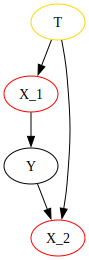

In [30]:
g = gr.Digraph()

g.edge("T", "X_1"), g.node("T", color="gold"), g.edge("X_1", "Y"), g.node("X_1", color="red")
g.edge("T", "X_2"), g.edge("Y", "X_2"), g.node("X_2", color="red")

g

Link to issue: https://github.com/matheusfacure/python-causality-handbook/issues/261

## Key Ideas

In this section, we've looked at variables that are not confounders and if we should add them or not to our model for causal identification. We've seen that variables that are good predictors of the outcome $Y$ should be added to the model even if they don't predict $T$ (are not confounders). This is because predicting $Y$ lowers its variance and makes it more likely that we will see statistically significant results when estimating the causal effect. Next, we've seen that it is a bad idea to add variables that predict the treatment but not the outcome. Those variables reduce the variability of the treatment, making it harder for us to find the causal effect. Finally, we've looked at selection bias. This is bias that arises when we control for variables in the causal path from the treatment to the outcome or variables that are common effects of the treatment and the outcome.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).

# Issue

Issue: https://github.com/matheusfacure/python-causality-handbook/issues/261

@imurray
As the chapter says, the two-part decomposition that's described is true, and (unlike what the chapter seems to say) each part can be estimated from the observable data. Just to be explicit, there's python code for a toy example below. As we should expect, we get precisely the same E[Y|T] and ATE values regardless of whether we estimate the expectation directly for each treatment, or break the estimate for each treatment into two parts.

Is the "bias" the chapter describes from assuming the expectation is something it's not? The relevant examples for the conditioned-on-positive (COP) expectation really can change under treatment, which is a valid part of estimating the effect of the treatment. I think the chapter must be warning against some wrong use or interpretation of the COP expectation? Perhaps using it in place of E[Y|T], which would just be wrong? But I can't find where the chapter is specific about what the wrong procedure is. Instead, the whole approach is deemed flawed.

The two-step approach (also known as a [hurdle model](https://en.wikipedia.org/wiki/Hurdle_model)) is a natural and sensible model for data with a spike at zero. There's no point adding the complication for the toy example below (it's not wrong, it just makes no difference), but where we need to control for other variables, the added structure of the two-step approach often leads to a parametric model that fits real-world data better. I don't think "Data Scientists" are ignorant for using this style of model!

If there really is a reason to avoid this modelling approach "like the plague", I'd love to understand it, but I think the chapter needs to be more specific about its claims.

@matheusfacure
You are correct. This part needs some rewriting because its is very confusing. What I meant there was that doing p1 (cop1-cop2) was the problem. This is more common than you might think as ppl expect that the effect of the treatment will be the effect on those that converted (cop) times the conversion rate. This will NOT recover the effect on the converted, which is what ppl think


308.86326276588113
308.8632627658812


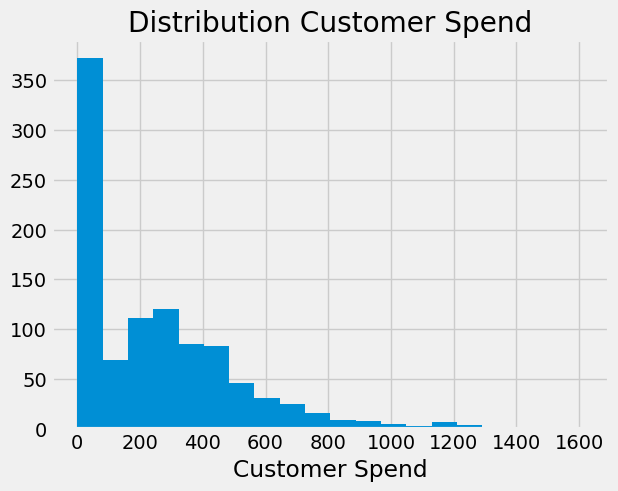

In [31]:
import numpy as np

N = 1000

# Unobserved property for each individual:
rich = np.random.rand(N) < 0.3

# Random assignment of treatments, independent of "rich":
treated = np.random.rand(N) < 0.2

# Create model params for each example, depending on whether in control or treated.
# Can interact with latent variable "rich".
gparam_1 = 5 + 2*rich + 3*treated + rich*treated
gparam_2 = 50 + 10*rich + 20*treated + 5*rich*treated
hurdle_probs = 0.6 + 0.2*treated
#hurdle_probs = rich | treated # would work fine too

# Simulate data
mask = np.random.rand(N) < hurdle_probs
Y = mask * np.random.gamma(gparam_1, gparam_2, N)

plt.hist(Y, bins=20)
plt.xlabel("Customer Spend")
plt.title("Distribution Customer Spend")

# Straightforward estimate of Average Treatment Effect (ATE)
ATE1 = Y[treated].mean() - Y[~treated].mean()
print(ATE1)

# Two part estimates, only depend on observed data, and known treatment labels:
p0 = (Y[~treated] > 0).mean()
p1 = (Y[treated] > 0).mean()
cop0 = (Y[~treated & (Y > 0)]).mean()
cop1 = (Y[treated & (Y > 0)]).mean()

# Estimate of ATE using the 2-part estimates:
ATE2 = p1*cop1 - p0*cop0
print(ATE2) # the same as before

In [32]:
Y[treated]>0

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
       False,  True, False, False, False,  True, False, False,  True,
        True,  True,  True, False, False, False, False,  True, False,
       False,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False, False,  True, False,  True, False,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True, False, False, False,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,